# Data Preprocessing and Exploratory Data Analysis

## 1. Introduction
**Objective:** Load, clean, and analyze historical financial data for Tesla (TSLA), Vanguard Total Bond Market ETF (BND), and S&P 500 ETF (SPY) to prepare for forecasting and portfolio optimization.

**Context:**
*   **TSLA:** High growth, high volatility (Consumer Discretionary).
*   **BND:** Stability, low risk (Bonds).
*   **SPY:** Market benchmark, moderate risk (Equities).

## 2. Setup and Imports
Importing standard libraries and our custom modules from `src`.

In [3]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt

# Add the project root to the path so we can import from src
sys.path.append(os.path.abspath(os.path.join('..')))

from src.loader import DataLoader
from src.preprocessing import clean_data, get_adj_close, calculate_returns
from src.eda import plot_closing_prices, plot_daily_returns, plot_rolling_stats, check_stationarity, decompose_series, calculate_risk_metrics

## 3. Data Extraction
We fetch data from **Jan 1, 2015** to **Jan 15, 2026** (as per current date context).

In [2]:
tickers = ['TSLA', 'BND', 'SPY']
start_date = '2015-01-01'
end_date = '2026-01-15'

loader = DataLoader(start_date, end_date)
raw_data = loader.fetch_data(tickers)

# Display the first few rows to understand structure
raw_data.head()

Fetching data for ['TSLA', 'BND', 'SPY'] from 2015-01-01 to 2026-01-15...


[*********************100%***********************]  3 of 3 completed

Data successfully fetched from API.


Ticker             SPY                                                 \
Price             Open        High         Low       Close     Volume   
Date                                                                    
2015-01-02  171.378508  171.793709  169.551612  170.589615  121465900   
2015-01-05  169.543319  169.709397  167.201590  167.508835  169632600   
2015-01-06  167.816066  168.339223  165.133869  165.931061  209151400   
2015-01-07  167.259706  168.339232  166.811294  167.998764  125346700   
2015-01-08  169.410413  171.195786  169.393814  170.979874  147217800   

Ticker            BND                                                 TSLA  \
Price            Open       High        Low      Close   Volume       Open   
Date                                                                         
2015-01-02  60.225226  60.415189  60.217918  60.385963  2218800  14.858000   
2015-01-05  60.451719  60.583231  60.422494  60.561314  5820100  14.303333   
2015-01-06  60.663572  60.919289  60.663572  60.736633  3887600  14.004000   
2015-01-07  60.743968  60.846255  60.678214  60.773193  2433400  14.223333   
2015-01-08  60.722070  60.722070  60.619783  60.678234  1873400  14.187333   

Ticker                                                 
Price            High        Low      Close    Volume  
Date                                                   
2015-01-02  14.883333  14.217333  14.620667  71466000  
2015-01-05  14.433333  13.810667  14.006000  80527500  
2015-01-06  14.280000  13.614000  14.085333  93928500  
2015-01-07  14.318667  13.985333  14.063333  44526000  
2015-01-08  14.253333  14.000667  14.041333  51637500

## 4. Data Cleaning
We perform the following checks:
1.  Check for missing values (fill or drop).
2.  Verify data types.
3.  Extract `Adj Close` specifically for analysis.

In [4]:
# Clean the raw data (handle NaNs)
cleaned_data = clean_data(raw_data)

# Extract Adjusted Close prices for the 3 assets
adj_close_df = get_adj_close(cleaned_data, tickers)
adj_close_df.head()

Checking for missing values...
No missing values found.


,TSLA,BND,SPY
Date,,,
2015-01-02,14.620667,60.385963,170.589615
2015-01-05,14.006000,60.561314,167.508835
2015-01-06,14.085333,60.736633,165.931061
2015-01-07,14.063333,60.773193,167.998764
2015-01-08,14.041333,60.678234,170.979874


## 5. Exploratory Data Analysis (EDA)

### 5.1 Historical Closing Prices
Visualizing the price trend over the last decade.

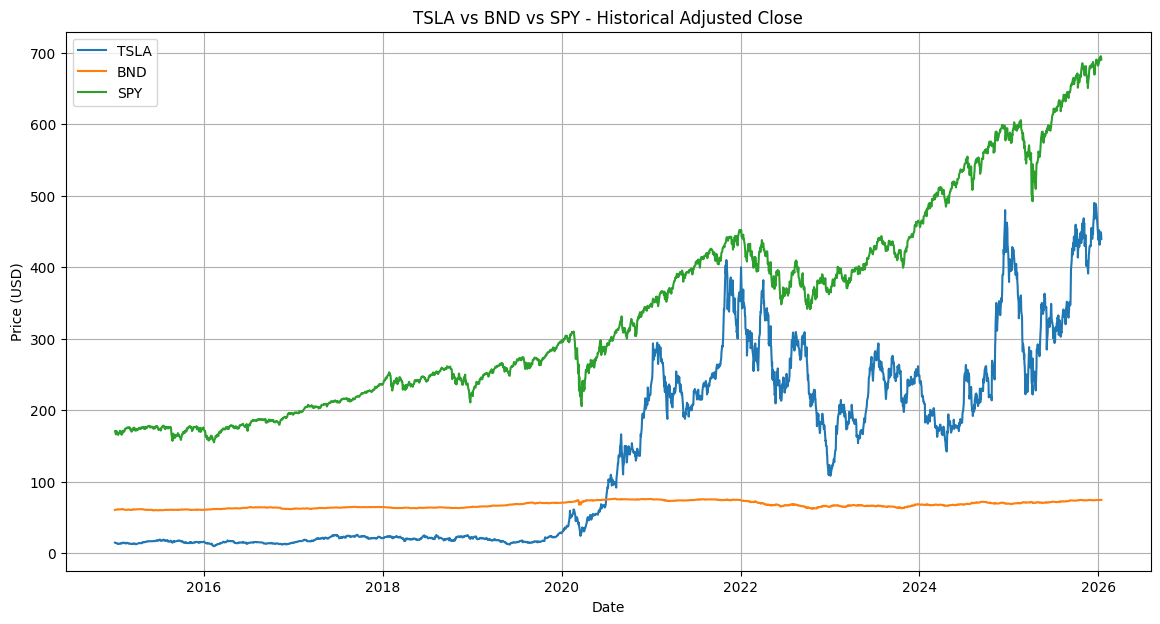

In [5]:
plot_closing_prices(adj_close_df, title="TSLA vs BND vs SPY - Historical Adjusted Close")

### 5.2 Daily Returns & Volatility
Calculating daily percentage changes to observe volatility clusters.

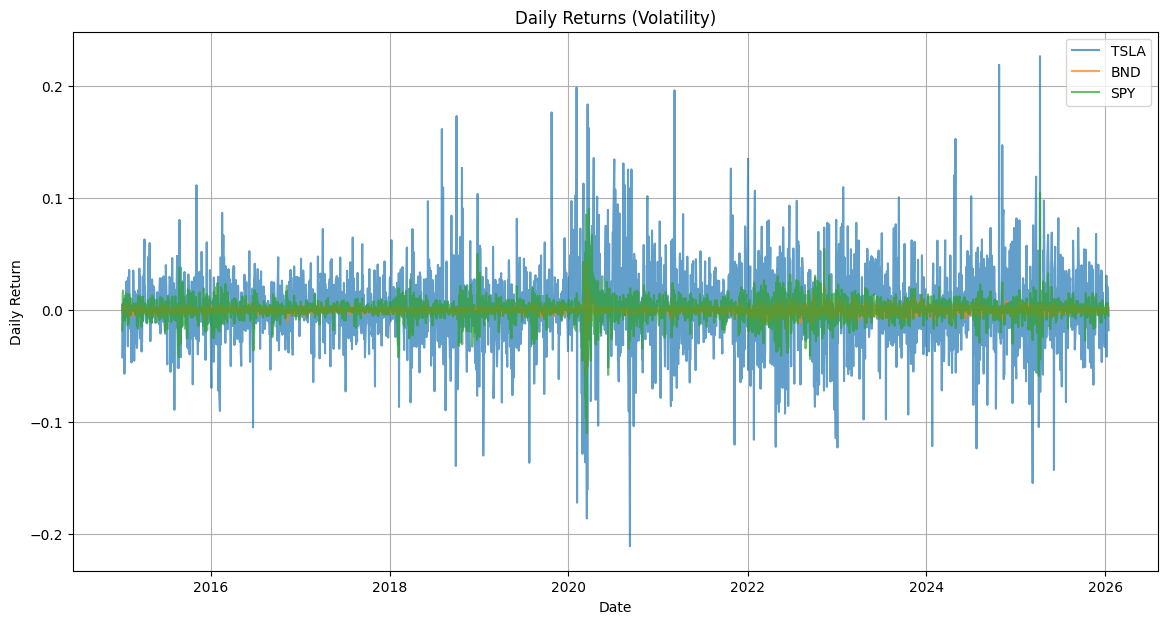

In [6]:
daily_returns = calculate_returns(adj_close_df)
plot_daily_returns(daily_returns)

### 5.3 Rolling Volatility (Standard Deviation)
We use a 30-day rolling window to visualize how risk changes over time.

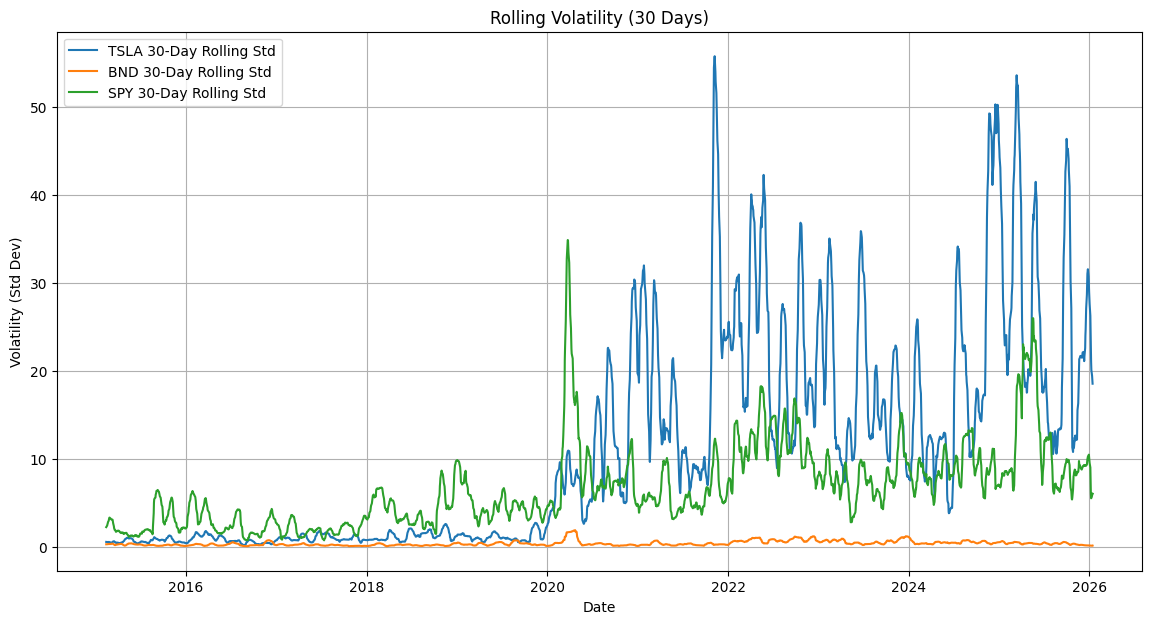

In [7]:
plot_rolling_stats(adj_close_df, window=30)

## 6. Time Series Decomposition
Decomposing **TSLA** into Trend, Seasonality, and Residuals to understand underlying patterns.

Decomposing TSLA Data...


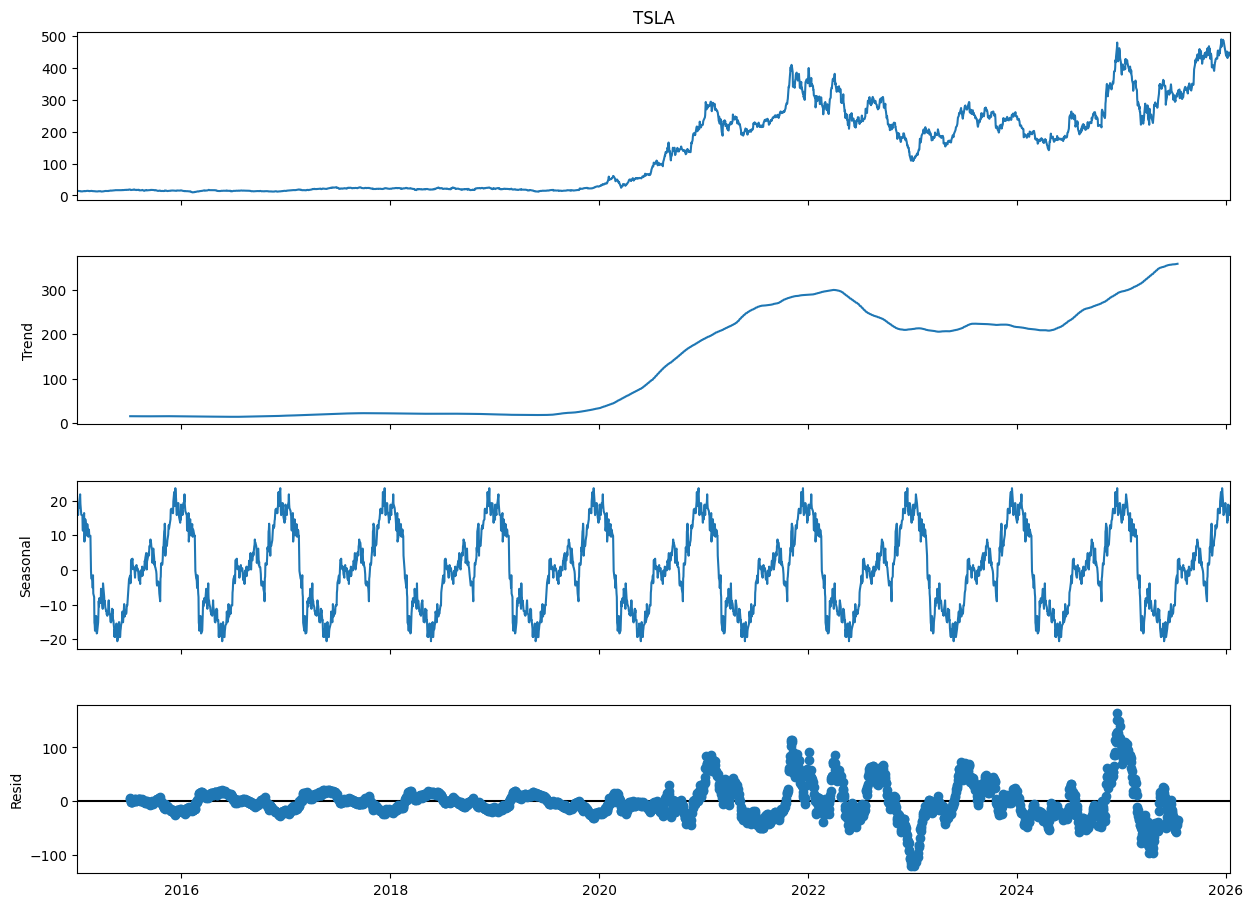

In [8]:
print("Decomposing TSLA Data...")
# We use 'additive' model here since the random data might not scale multiplicatively like real stocks
decompose_series(adj_close_df['TSLA'], model='additive', period=252)

# 7. Stationarity Test (Augmented Dickey-Fuller)
- ARIMA models require stationary data (constant mean and variance).
- We test both the Closing Price (usually non-stationary) and Returns (usually stationary).

In [10]:
print(">>> TEST 1: TSLA Raw Prices (Level)")
check_stationarity(adj_close_df['TSLA'], name="TSLA Closing Price")

print("\n>>> TEST 2: TSLA Daily Returns (Differenced)")
check_stationarity(daily_returns['TSLA'], name="TSLA Daily Returns")

>>> TEST 1: TSLA Raw Prices (Level)

--- Augmented Dickey-Fuller Test: TSLA Closing Price ---
ADF Statistic : -1.4369537251396693
p-value : 0.5644374984400881
#Lags Used : 15
Number of Observations Used : 2865
Result: Weak evidence against null hypothesis, time series has a unit root, indicating it is NON-STATIONARY.

>>> TEST 2: TSLA Daily Returns (Differenced)

--- Augmented Dickey-Fuller Test: TSLA Daily Returns ---
ADF Statistic : -25.642495167552756
p-value : 0.0
#Lags Used : 3
Number of Observations Used : 2876
Result: Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is STATIONARY.


# 8. Risk Analysis (VaR & Sharpe Ratio)
Quantifying risk helps in portfolio optimization.
- VaR (Value at Risk): Max expected loss at 95% confidence.
- Sharpe Ratio: Risk-adjusted return.


In [9]:
risk_metrics = calculate_risk_metrics(daily_returns)
print("Risk Metrics Summary:")
display(risk_metrics)

Risk Metrics Summary:


,VaR_95,Sharpe_Ratio,Annualized_Sharpe
TSLA,-0.052529,0.049672,0.788518
BND,-0.004796,0.000510,0.008097
SPY,-0.016719,0.043556,0.691427


# 9. Save Data for Task 2

In [10]:
# Saving the processed data to CSV for the forecasting notebook.

output_path = '../data/processed/cleaned_adj_close.csv'
adj_close_df.to_csv(output_path)
print(f"Data saved to {output_path}")

Data saved to ../data/processed/cleaned_adj_close.csv
